#**Income Driven: Exploring Relationships Between Vehicles and Household Income in New York State**
#Portfolio Project for RPAD 676: Data Science for the Public Good at SUNY Albany

## Author: Daniel Weinstein
## Date: April 16th, 2025


#Objective

Personal vehicles are essential for both work and leisure, especially when public transportation is not readily available. However, vehicles also impose significant costs, in both purchase and upkeep, on their owners, and this burden is felt more for households/families in lower socioeconomic brackets.
Using a combination of New York State Department of Motor Vehicles (DMV) vehicle registration data and demographic/economic data from the U.S. Census Bureau, this project seeks to explore trends in vehicle ownership as well as relationships between vehicles and socioeconomic indicators across geographic locations in New York State. This may reveal trends that guide further research and analysis directions about the state of vehicles in New York.

# Methods and Analysis


## Preparation

In [5]:
# load libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [6]:
# load datasets

# Load the vehicle registration .csv file (Filtered for Record Type = Vehicle)
veh_registrations_base = pd.read_csv('/content/drive/MyDrive/NYVehicles/vehicle_registrations.csv', parse_dates=['Reg Valid Date', 'Reg Expiration Date'])

# Load the ACS2023 County-Level Data
county_stats = pd.read_csv('/content/drive/MyDrive/NYVehicles/County_ACS2023_stats.csv')



### Filtering the Records Table

First, the dataset was downloaded as a .csv file from NY Open Data, filtering for only "Vehicle" record types. Then, I removed records where the registration was not located in New York, as can happen for some commercial and in-transit records. I then ensured uniform names in the county column. From there, I separated the dataset into three new sets: personal vehicles, non-agricultural commercial vehicles, and motorcycles. Finally, I filtered any personal vehicle records with a model year prior to 1980, assuming that vehicles older than that were likely kept by those interested in antique cars rather than as typical commuting vehicles, so as not to skew later analysis around average vehicle age.

Only the personal vehicles data was used for this analysis, but the code below could provide a framework to conduct analyses on commercial vehicle and motorcycle data in the future.

---



In [7]:
# Removing records for out-of-state vehicle registrations

veh_registrations_filter = veh_registrations_base[(veh_registrations_base['State'] == "NY") & (veh_registrations_base['County'] != "OUT-OF-STATE")]

# Removing Exlcuded Registration Types

codes_to_exclude = ["AGC", "ATV", "AGR", "AMB", "ARG", "AYG", "CBS", "CCK", "CLG", "DLR", "FAR", "GAC", "GSC", "HIS",
                    "ITP", "JCA", "JCL", "JSC", "LOC", "LTR", "NYA", "NYC", "NYS", "OMF", "OML", "OMO",
                    "OMR", "OMS", "OMT", "OMV", "PSD", "ORG", "SCL", "SEM", "SRN", "STA", "STG", "SUP",
                    "TRC", "TRL", "USC", "USS", "VAS"]

veh_registrations_filter = veh_registrations_filter[~veh_registrations_filter['Registration Class'].isin(codes_to_exclude)]

# Stating how many rows were removed and how many remain

row_count = veh_registrations_filter.shape[0]

print(f"There are now {row_count} entries present.")

There are now 10513615 entries present.


In [8]:
# Changing instances of County = QUEEN to QUEENS

veh_registrations_filter['County'] = veh_registrations_filter['County'].replace('QUEEN', 'QUEENS')

In [9]:
## Create separate dataframes of non-agricultural commercial vehicles and Motorcycles

commercial_codes = ["CHC", "COM", "CSP", "HIF", "HIR", "IRP", "RG", "RGC", "RGL", "SPC"]
motorcycle_codes = ["HSM", "LMA", "LMB", "LMC", "MOT", "MTR"]

reg_comm = veh_registrations_filter[veh_registrations_filter['Registration Class'].isin(commercial_codes)]
reg_mot = veh_registrations_filter[veh_registrations_filter['Registration Class'].isin(motorcycle_codes)]

## Create a data set excluding those in the commercial or motorcycle datasets

reg_pers = veh_registrations_filter[~veh_registrations_filter.index.isin(reg_comm.index)]
reg_pers = reg_pers[~reg_pers.index.isin(reg_mot.index)]

comm_rows = reg_comm.shape[0]
mot_rows = reg_mot.shape[0]
pers_rows = reg_pers.shape[0]

print(f"There are {comm_rows} commercial vehicles present.")
print(f"There are {mot_rows} motorcycles/registered motorbikes present.")
print(f"There are {pers_rows} non-commercial vehicles present.")

There are 696666 commercial vehicles present.
There are 344031 motorcycles/registered motorbikes present.
There are 9472918 non-commercial vehicles present.


In [10]:
# Excluding remaining personal registrations with a model year prior to 1980

reg_pers = reg_pers[reg_pers['Model Year'] >= 1980]
pers_rows = reg_pers.shape[0]
print(f"There are now {pers_rows} non-commercial vehicles present.")

There are now 9377591 non-commercial vehicles present.


##Data Exploration and Analysis

### Vehicles and Population


As an initial exporation, I looked at the relationship between a county's population and the number of personal vehicles registered in that county. I expected this to be a relatively linear relationship, and so it proved a good way to assess the quality and validity of my data.


This showed that this was largely true, with the exception of some boroughs of New York City. This deviation is quite expected, however, due to the nature of transportation and vehicle ownership in boroughs like Manhattan, Brooklyn, Queens, and the Bronx. Because of this, I also created a separate data frame excluding the five NYC boroughs for comparison.

In [11]:
# Creating new dataframe for a count of vehicles by county.

county_counts = reg_pers.groupby('County').size().reset_index(name='Total Vehicles')

# Adding to this dataframe the total population and median household income columns for each county from the ACS2023 (county_stats dataframe)

county_counts = county_counts.merge(county_stats[['County', 'total_population', 'median_household_income']], how='inner', on='County')

# Make the columns Count, total_population, and median_household_income into numbers
county_counts['Total Vehicles'] = pd.to_numeric(county_counts['Total Vehicles'])
county_counts['total_population'] = pd.to_numeric(county_counts['total_population'].str.replace(',', ''))
county_counts['median_household_income'] = pd.to_numeric(county_counts['median_household_income'].str.replace(',', ''))

county_counts


,County,Total Vehicles,total_population,median_household_income
0,ALBANY,188986,315374,83149
1,ALLEGANY,27219,47027,61233
2,BRONX,230835,1419250,49036
3,BROOME,121134,197738,61059
4,CATTARAUGUS,46452,76479,58248
...,...,...,...,...
57,WASHINGTON,41627,60883,72342
58,WAYNE,64450,91128,73914
59,WESTCHESTER,622372,996888,118411
60,WYOMING,25059,39980,68913


In [12]:
# Creating a dataframe excluding the five NYC boroughs

county_counts_nonyc = county_counts[~county_counts['County'].isin(['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND'])]

# Creating a dataframe for downstate NY (NYS DOT Regions 10, 11, and lower counties of Region 8) and upstate NY only.

county_counts_upstate = county_counts[~county_counts['County'].isin(['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND', 'PUTNAM', 'WESTCHESTER', 'NASSAU', 'SUFFOLK'])]
county_counts_downstate = county_counts[county_counts['County'].isin(['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND', 'PUTNAM', 'WESTCHESTER', 'NASSAU', 'SUFFOLK'])]

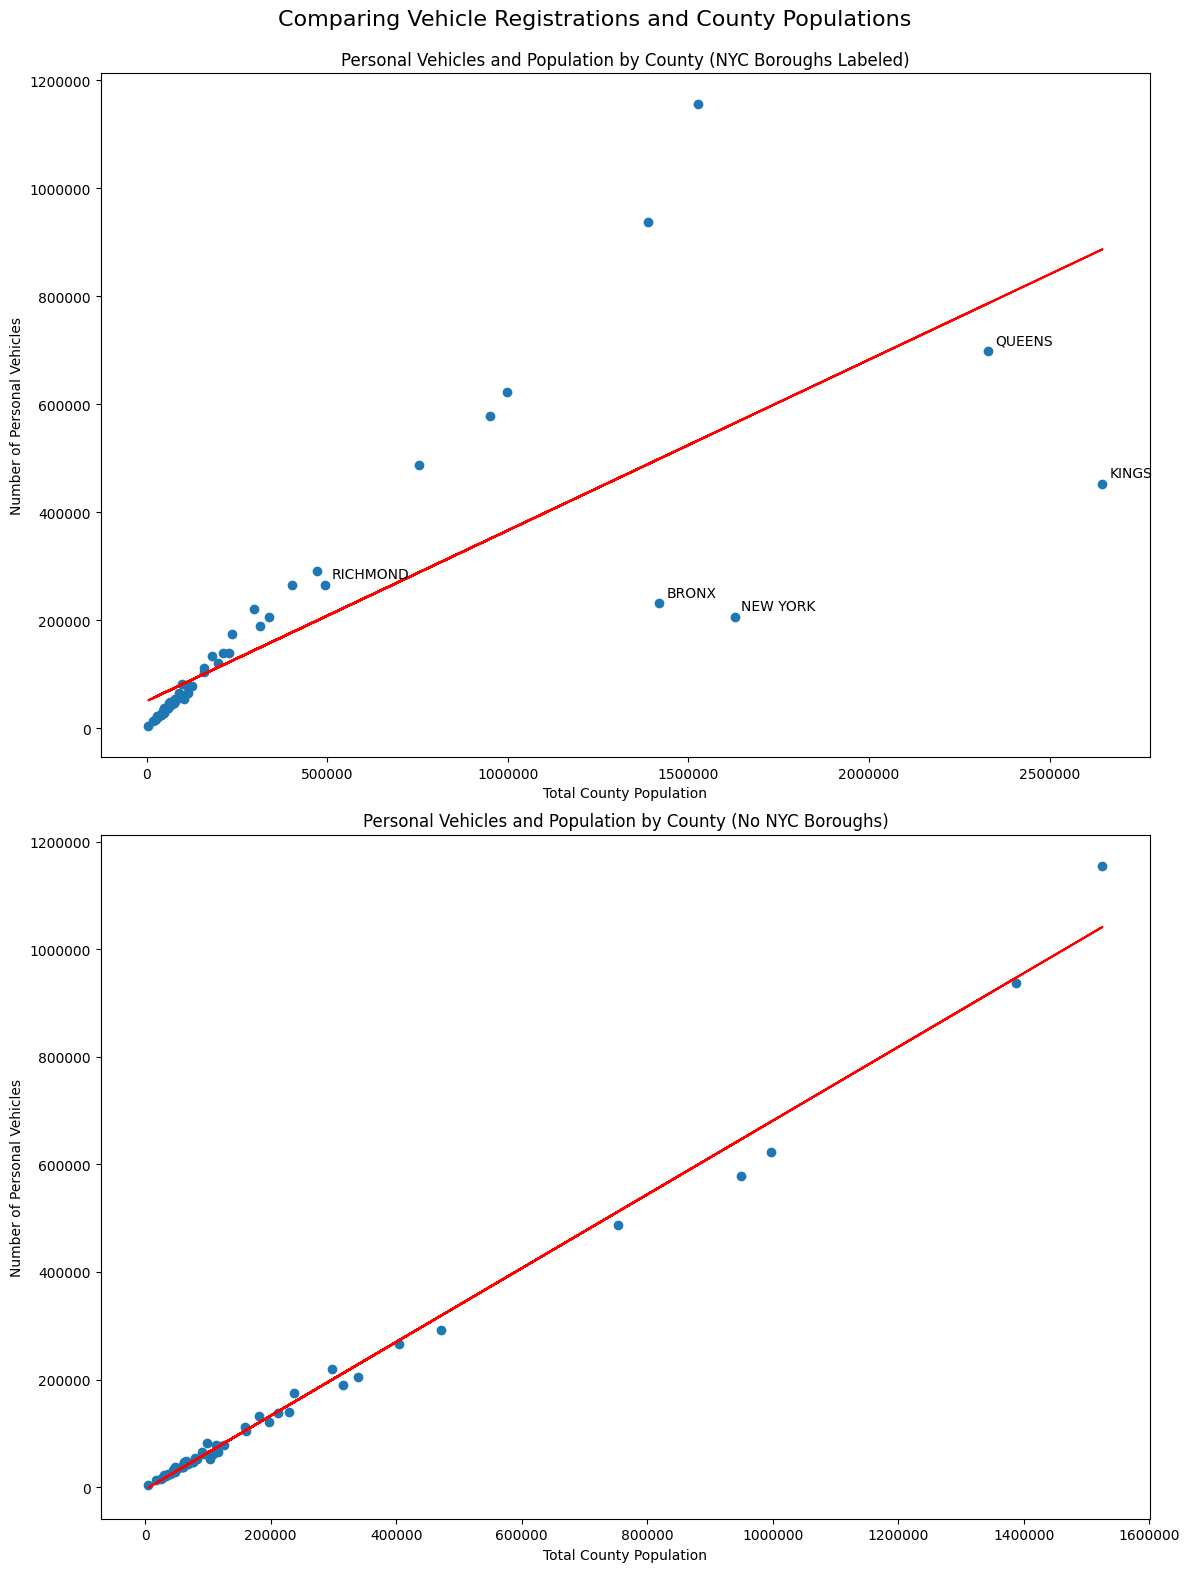

Correlation Excluding NYC Boroughs:
Correlation Coefficient: 0.9951196376150943
P-value: 5.169070740783398e-57


In [13]:
# Visualizing the Relationship Between County Population and Number of Registered Vehicles

plt.figure(figsize=(12, 16))

# Plot 1: All Data Points

plt.subplot(2, 1, 1)
plt.scatter('total_population', 'Total Vehicles', data=county_counts)
plt.title('Personal Vehicles and Population by County (NYC Boroughs Labeled)')
plt.xlabel("Total County Population")
plt.ylabel("Number of Personal Vehicles")
plt.ticklabel_format(axis='both', style='plain')

# Annotate NYC Boroughs to demonstrate outliers.
counties_to_annotate = ['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND']
for county in counties_to_annotate:
    x = county_counts[county_counts['County'] == county]['total_population'].values[0]
    y = county_counts[county_counts['County'] == county]['Total Vehicles'].values[0]
    plt.annotate(county, (x, y), textcoords="offset points", xytext=(5,5), ha='left')

# Add a trend line with a label
z1 = np.polyfit(county_counts['total_population'], county_counts['Total Vehicles'], 1)
p1 = np.poly1d(z1)
plt.plot(county_counts['total_population'], p1(county_counts['total_population']), color='red', label='TrendLine')

# Plot 2: Exclude NYC
plt.subplot(2, 1, 2)
plt.scatter('total_population', 'Total Vehicles', data=county_counts_nonyc)
plt.title('Personal Vehicles and Population by County (No NYC Boroughs)')
plt.xlabel('Total County Population')
plt.ylabel('Number of Personal Vehicles')
plt.ticklabel_format(axis='both', style='plain')

# Add a trendline
z2 = np.polyfit(county_counts_nonyc['total_population'], county_counts_nonyc['Total Vehicles'], 1)
p2 = np.poly1d(z2)
plt.plot(county_counts_nonyc['total_population'], p2(county_counts_nonyc['total_population']), color='red', label='TrendLine')

plt.tight_layout()
plt.suptitle('Comparing Vehicle Registrations and County Populations', fontsize=16)
plt.subplots_adjust(top=0.94)
plt.show()

correlation_coefficient, p_value = stats.pearsonr(county_counts_nonyc['total_population'], county_counts_nonyc['Total Vehicles'])

print('Correlation Excluding NYC Boroughs:')

print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")



When excluding the five NYC boroughs, I found a mostly linear relationship between county population and the number of vehicles registered, with some minor outliers on the higher end of median income scale.

### Vehicles and Median Income


To do further analysis, I needed to control for  the relationship I found between population and vehicle registrations. Since this relationship was mostly linear among non-NYC counties, I simply created a variable "Vehicles per Capita" by dividing the number of vehicle registrations by the total population for each county. Due to the substantial outlier effect of the NYC boroughs, I excluded them from further analyses that were based on vehicle counts and populations.

In [14]:
# Create a column Vehicles Per Capita by dividing Count by total_population
county_counts['Vehicles Per Capita'] = county_counts['Total Vehicles'] / county_counts['total_population']

county_counts_nonyc = county_counts[~county_counts['County'].isin(['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND'])]

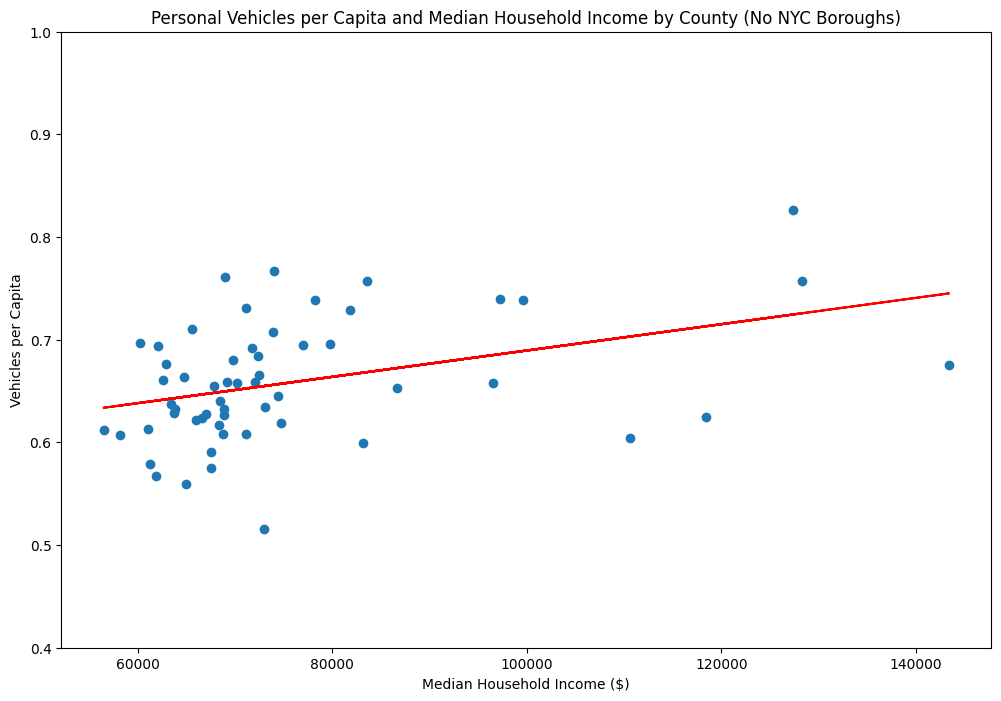

Correlation Excluding NYC Boroughs:
Correlation Coefficient: 0.39051389006295556
P-value: 0.0026712874529464838


In [15]:
# Visualizing the Relationship Between Vehicles per Capita and Median Household Income (Excluding NYC)

plt.figure(figsize=(12, 8))
plt.scatter('median_household_income', 'Vehicles Per Capita', data=county_counts_nonyc)
plt.title('Personal Vehicles per Capita and Median Household Income by County (No NYC Boroughs)')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Vehicles per Capita')
plt.ylim(0.4,1)
plt.ticklabel_format(axis='both', style='plain')

# Add a trendline
z3 = np.polyfit(county_counts_nonyc['median_household_income'], county_counts_nonyc['Vehicles Per Capita'], 1)
p3 = np.poly1d(z3)
plt.plot(county_counts_nonyc['median_household_income'], p3(county_counts_nonyc['median_household_income']), color='red', label='TrendLine')
plt.show()

correlation_coefficient1, p_value1 = stats.pearsonr(county_counts_nonyc['median_household_income'], county_counts_nonyc['Vehicles Per Capita'])

print('Correlation Excluding NYC Boroughs:')

print(f"Correlation Coefficient: {correlation_coefficient1}")
print(f"P-value: {p_value1}")



This shows a moderate positive correlation between vehicles per capita and median household income. However, the higher end of the median income spectrum contains both high and low outliers. Some low outliers, such as Rockland and Nassau counties, may be explained by their relatively close proximity to NYC. However, due to the small sample size of counties on the higher half of the range of median household income, I wanted to see if the correlation continued to hold with a more concentrated sample size.

In [16]:
# Filter county_counts for counties with median income less than or equal to 100000
filtered_counties = county_counts[county_counts['median_household_income'] <= 100000]
filtered_counties


,County,Total Vehicles,total_population,median_household_income,Vehicles Per Capita
0,ALBANY,188986,315374,83149,0.599244
1,ALLEGANY,27219,47027,61233,0.578795
2,BRONX,230835,1419250,49036,0.162646
3,BROOME,121134,197738,61059,0.612598
4,CATTARAUGUS,46452,76479,58248,0.607382
5,CAYUGA,47089,75464,66583,0.623993
6,CHAUTAUQUA,77321,126329,56507,0.612061
7,CHEMUNG,52741,82805,63469,0.636930
8,CHENANGO,32394,46685,62093,0.693885
9,CLINTON,52059,78961,69208,0.659300


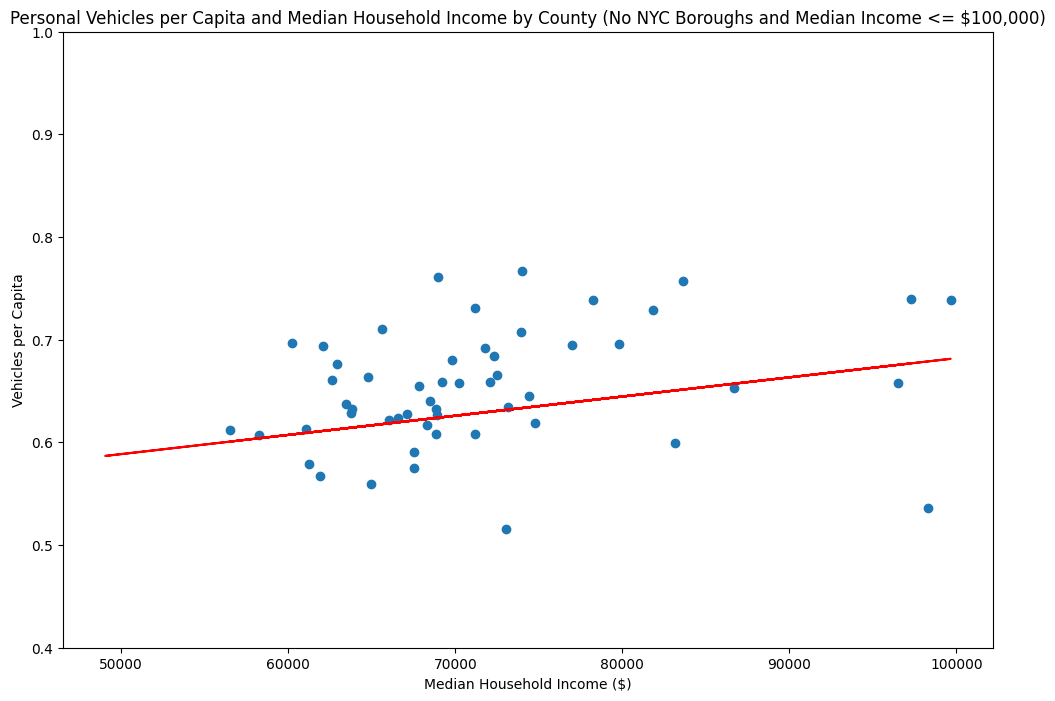

Correlation Excluding NYC Boroughs and Median Income > $100,000:
Correlation Coefficient: 0.16717743095794435
P-value: 0.21813084606225494


In [17]:
# Visualizing the Relationship Between Vehicles per Capita and Median Household Income (Excluding NYC and Counties with Greater Than 100,000 Median Household Income)

plt.figure(figsize=(12, 8))
plt.scatter('median_household_income', 'Vehicles Per Capita', data=filtered_counties)
plt.title('Personal Vehicles per Capita and Median Household Income by County (No NYC Boroughs and Median Income <= $100,000)')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Vehicles per Capita')
plt.ylim(0.4,1)
plt.ticklabel_format(axis='both', style='plain')

# Add a trendline
z3 = np.polyfit(filtered_counties['median_household_income'], filtered_counties['Vehicles Per Capita'], 1)
p3 = np.poly1d(z3)
plt.plot(filtered_counties['median_household_income'], p3(filtered_counties['median_household_income']), color='red', label='TrendLine')
plt.show()

correlation_coefficient2, p_value2 = stats.pearsonr(filtered_counties['median_household_income'], filtered_counties['Vehicles Per Capita'])

print('Correlation Excluding NYC Boroughs and Median Income > $100,000:')

print(f"Correlation Coefficient: {correlation_coefficient2}")
print(f"P-value: {p_value2}")


Based on the results of the latter plot, the relationship is likely more attributable to other factors, such as geographic, cultural, and economic variations between counties.

### Vehicle Age and Median Income

If there was a spurious correlation between total vehicles and median income, what about the characteristics of those vehicles? I first analyzed the average vehicle age in relation in median household income

In [ ]:
# Calculate the age of each vehicle by subtracting the Model Year from the current year

import datetime

# Retrieve the current year
current_year = datetime.datetime.now().year

# Calculate the age of each vehicle
reg_pers['Vehicle_Age'] = current_year - reg_pers['Model Year']

# Return the average vehicle_age, grouped by county
average_vehicle_age = reg_pers.groupby('County')['Vehicle_Age'].mean().reset_index()


In [21]:
# Join the average vehicle age data to the county_counts dataframe

county_counts = county_counts.merge(average_vehicle_age, on='County')

county_counts

,County,Total Vehicles,total_population,median_household_income,Vehicles Per Capita,Vehicle_Age
0,ALBANY,188986,315374,83149,0.599244,8.592023
1,ALLEGANY,27219,47027,61233,0.578795,10.503545
2,BRONX,230835,1419250,49036,0.162646,10.003128
3,BROOME,121134,197738,61059,0.612598,9.843165
4,CATTARAUGUS,46452,76479,58248,0.607382,9.851481
...,...,...,...,...,...,...
57,WASHINGTON,41627,60883,72342,0.683721,9.961563
58,WAYNE,64450,91128,73914,0.707247,9.643957
59,WESTCHESTER,622372,996888,118411,0.624315,8.523354
60,WYOMING,25059,39980,68913,0.626788,9.748833


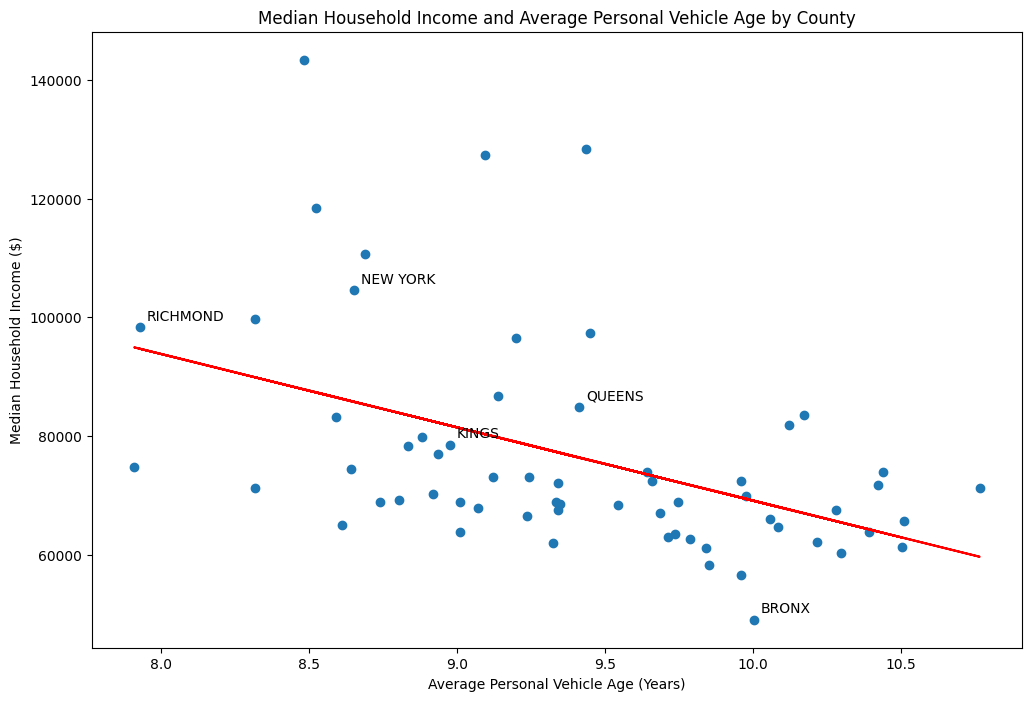

Correlation:
Correlation Coefficient: -0.4551263794421309
P-value: 0.00020191321910293392


In [22]:
# Visualizing the Relationship Between Median Household Income and Average Personal Vehicle Age

plt.figure(figsize=(12, 8))
plt.scatter('Vehicle_Age', 'median_household_income', data=county_counts)
plt.title('Median Household Income and Average Personal Vehicle Age by County')
plt.xlabel('Average Personal Vehicle Age (Years)')
plt.ylabel('Median Household Income ($)')
plt.ticklabel_format(axis='both', style='plain')

# Annotate NYC Boroughs
counties_to_annotate = ['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND']
for county in counties_to_annotate:
    x = county_counts[county_counts['County'] == county]['Vehicle_Age'].values[0]
    y = county_counts[county_counts['County'] == county]['median_household_income'].values[0]
    plt.annotate(county, (x, y), textcoords="offset points", xytext=(5,5), ha='left')

# Add a trendline
z4 = np.polyfit(county_counts['Vehicle_Age'], county_counts['median_household_income'], 1)
p4 = np.poly1d(z4)
plt.plot(county_counts['Vehicle_Age'], p4(county_counts['Vehicle_Age']), color='red', label='TrendLine')
plt.show()

correlation_coefficient3, p_value3 = stats.pearsonr(county_counts['Vehicle_Age'], county_counts['median_household_income'])

print('Correlation:')

print(f"Correlation Coefficient: {correlation_coefficient3}")
print(f"P-value: {p_value3}")


### Luxury Vehicle Percentages

Next,  I wanted to ascertain not only any relationships between vehicle age and
median household income, but also the makes of cars that were owned. This analysis was especially challenging for two main reasons:

First, for passenger vehicles, there are 2,444 unique values for makes in the dataset. However, There are only 122 with a count greater than 100. Further, there are often duplicates with different spellings: a Porsche can be documented as "PORSC," "PORCH," "PORSH," "PORS," and so on. Oftentimes, the duplicates make a small percentage of the total. PORSC, for example, has 41,081 records, while PORSH has only 64. For common brands such as Toyota or Ford, this is usually trivial, but for less common cars, especially luxury brands, the number may be underestimated based on using only the most common make codes.

Second, for the purposes of this analysis I've used generative AI tools to provide estimates for classifications of vehicle makes in Luxury, Semi-Luxury, and Non-Luxury categories. There is not, however, always a 1:1 relationship between a vehicle make and its luxury status. Toyotas are common non-luxury vehicles, but they also have their own "Premium" models (https://www.toyota.com/premium-cars/). Even the term "luxury" or "premium" brand is not extremely well-defined, and is in large part based on consumer sentiment and price tag.

As such, the results of this should be taken as exploratory, with a more thorough analysis and classifcation conducted to truly investigate a potential trend. The dataset, however, only provides the make of the vehicle, and not the model.

In [23]:
# Making categories of luxury, semi-luxury, and non-luxury brands present in the dataset

luxury_brands = [
    'me/be', 'merz', 'bmw', 'porsc', 'jaguar', 'land rover', 'range rover',
    'maserati', 'bentl', 'rolls-royce', 'ferrar', 'ferra', 'lambo', 'la/ro', 'genes', 'jagua', 'saab', 'al/ro'
    'aston martin', 'maybach', 'bugatti', 'mclaren', 'lotus'
]

semi_luxury_brands = [
    'audi', 'lexus', 'cadil', 'linco', 'infin', 'acura', 'volvo',
    'genes', 'tesla', 'mini', 'buick', 'chrys', 'mercu'
]

non_luxury_brands = [
    'toyot', 'honda', 'ford', 'chevr', 'chevy', 'nissa', 'hyund', 'kia',
    'mazda', 'subar', 'volks', 'mitsu', 'dodge', 'jeep',
    'gmc', 'ram'
]


# Create a function to classify each vehicle make
def classify_vehicle(make):
    make_lower = make.lower()

    if any(brand in make_lower for brand in luxury_brands):
        return 'Luxury'
    elif any(brand in make_lower for brand in semi_luxury_brands):
        return 'Semi-Luxury'
    elif any(brand in make_lower for brand in non_luxury_brands):
        return 'Non-Luxury'
    else:
        return 'null'

reg_pers_makes = reg_pers.copy()

reg_pers_makes['Make'] = reg_pers_makes['Make'].astype(str)

# Apply the classification to the dataset
reg_pers_makes['Vehicle_Category'] = reg_pers_makes['Make'].apply(classify_vehicle)

In [24]:
# Remove rows where 'Vehicle_Category' is null
initial_row_count = len(reg_pers_makes)
reg_pers_makes_nonull= reg_pers_makes[reg_pers_makes['Vehicle_Category'] != 'null']
rows_removed = initial_row_count - len(reg_pers_makes_nonull)
rows_remaining = len(reg_pers_makes_nonull)

print(f"{rows_removed} rows were removed.")
print(f"There are now {rows_remaining} rows remaining.")


112460 rows were removed.
There are now 9265131 rows remaining.


In [ ]:
# Find totals of each category, grand total, and percent of total of each category by county

# Group by county and vehicle category, then count

county_makescat = reg_pers_makes_nonull.groupby(['County', 'Vehicle_Category'])['Vehicle_Category'].count().unstack(fill_value=0)

# Calculate the total number of vehicles for each county

county_makescat['Total'] = county_makescat.sum(axis=1)

# Calculate the percent of vehicles in each category by county

county_makescat['Percent_Luxury'] = (county_makescat['Luxury'] / county_makescat['Total']) * 100
county_makescat['Percent_Semi_Luxury'] = (county_makescat['Semi-Luxury'] / county_makescat['Total']) * 100
county_makescat['Percent_Non_Luxury'] = (county_makescat['Non-Luxury'] / county_makescat['Total']) * 100

In [26]:
# Add Total Population and Median Household Income to the County Vehicle Makes Table

# Rename the 'County' column in county_stats to match the column name in county_vehicle_counts
county_stats = county_stats.rename(columns={'county': 'County'})

# Merge the dataframes on the 'County' column
county_makescat = county_makescat.merge(county_stats[['County', 'total_population', 'median_household_income']], on='County', how='left')

# Ensure the population and income columns are numerical.

county_makescat['total_population'] = pd.to_numeric(county_makescat['total_population'].astype(str).str.replace(',', ''), errors='coerce')
county_makescat['median_household_income'] = pd.to_numeric(county_makescat['median_household_income'].astype(str).str.replace(',', ''), errors='coerce')

# Display the merged dataframe
county_makescat

,County,Luxury,Non-Luxury,Semi-Luxury,Total,Percent_Luxury,Percent_Semi_Luxury,Percent_Non_Luxury,total_population,median_household_income
0,ALBANY,10314,157363,19231,186908,5.518223,10.289019,84.192758,315374,83149
1,ALLEGANY,291,24039,2351,26681,1.090664,8.811514,90.097822,47027,61233
2,BRONX,18993,180889,28954,228836,8.299830,12.652729,79.047440,1419250,49036
3,BROOME,3746,105815,9959,119520,3.134203,8.332497,88.533300,197738,61059
4,CATTARAUGUS,555,41169,3836,45560,1.218174,8.419666,90.362160,76479,58248
...,...,...,...,...,...,...,...,...,...,...
57,WASHINGTON,767,37748,2491,41006,1.870458,6.074721,92.054821,60883,72342
58,WAYNE,1056,56995,5116,63167,1.671759,8.099166,90.229075,91128,73914
59,WESTCHESTER,73669,438101,104138,615908,11.961040,16.908045,71.130916,996888,118411
60,WYOMING,244,22482,1832,24558,0.993566,7.459891,91.546543,39980,68913


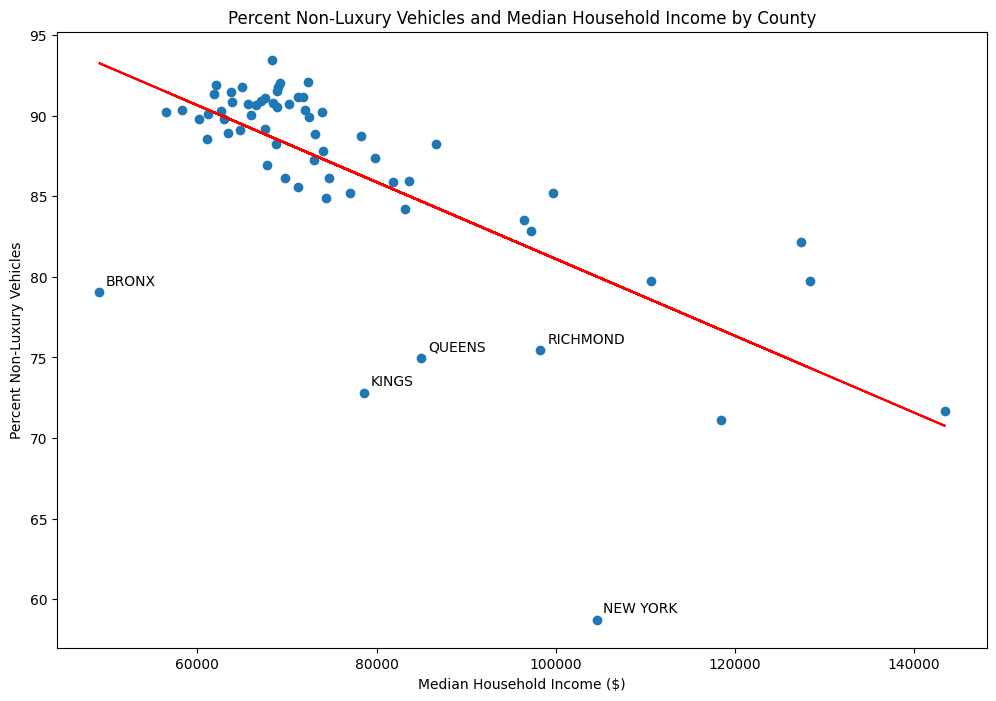

Correlation:
Correlation Coefficient: -0.6863241280481776
P-value: 7.406991743742912e-10


In [27]:
# Visualizing the Relationship Between Percent of Luxury Vehicles and Median Household Income by County

plt.figure(figsize=(12, 8))
plt.scatter('median_household_income', 'Percent_Non_Luxury', data=county_makescat)
plt.title('Percent Non-Luxury Vehicles and Median Household Income by County')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Percent Non-Luxury Vehicles')
plt.ticklabel_format(axis='both', style='plain')

# Annotate NYC Boroughs to demonstrate outliers.
counties_to_annotate = ['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND']
for county in counties_to_annotate:
    x = county_makescat[county_makescat['County'] == county]['median_household_income'].values[0]
    y = county_makescat[county_makescat['County'] == county]['Percent_Non_Luxury'].values[0]
    plt.annotate(county, (x, y), textcoords="offset points", xytext=(5,5), ha='left')

# Add a trendline
z4 = np.polyfit(county_makescat['median_household_income'], county_makescat['Percent_Non_Luxury'], 1)
p4 = np.poly1d(z4)
plt.plot(county_makescat['median_household_income'], p4(county_makescat['median_household_income']), color='red', label='TrendLine')
plt.show()

correlation_coefficient3, p_value3 = stats.pearsonr(county_makescat['median_household_income'], county_makescat['Percent_Non_Luxury'])

print('Correlation:')
print(f"Correlation Coefficient: {correlation_coefficient3}")
print(f"P-value: {p_value3}")

We see again that the NYC Boroughs are outliers, but across the whole range of median incomes. I filtered these counties to analyze the trends outside of NYC.

In [ ]:
# Filter county_makescat to exclude NYC

county_makescat1 = county_makescat[~county_makescat['County'].isin(['QUEENS', 'KINGS', 'BRONX', 'NEW YORK', 'RICHMOND'])]


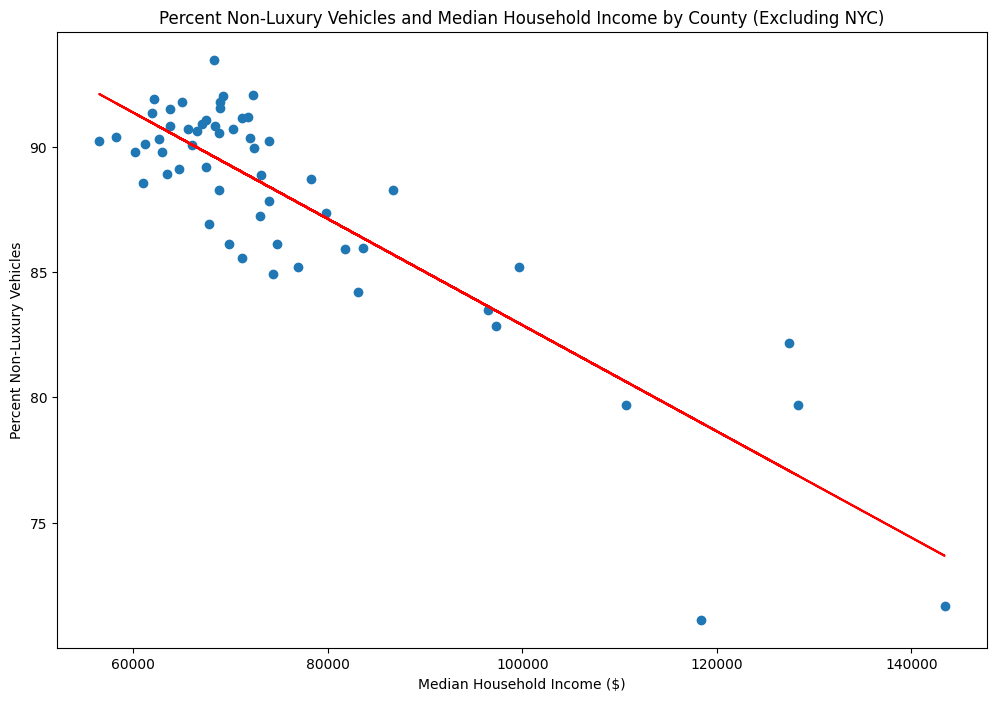

Correlation:
Correlation Coefficient: -0.8696018454518146
P-value: 1.7025748461426103e-18


In [31]:
# Visualizing the Relationship Between Percent of Luxury Vehicles and Median Household Income by County (Excluding NYC)

plt.figure(figsize=(12, 8))
plt.scatter('median_household_income', 'Percent_Non_Luxury', data=county_makescat1)
plt.title('Percent Non-Luxury Vehicles and Median Household Income by County (Excluding NYC)')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Percent Non-Luxury Vehicles')
plt.ticklabel_format(axis='both', style='plain')

# Add a trendline
z5 = np.polyfit(county_makescat1['median_household_income'], county_makescat1['Percent_Non_Luxury'], 1)
p5 = np.poly1d(z5)
plt.plot(county_makescat1['median_household_income'], p5(county_makescat1['median_household_income']), color='red', label='TrendLine')
plt.show()

correlation_coefficient4, p_value4 = stats.pearsonr(county_makescat1['median_household_income'], county_makescat1['Percent_Non_Luxury'])

print('Correlation:')
print(f"Correlation Coefficient: {correlation_coefficient4}")
print(f"P-value: {p_value4}")

Excluding NYC, there appears to be a moderate trend between median household income and the percentage of luxury versus non-luxury vehicles registered in that county. The other downstate counties, such as Nassua, Westchester, and Putnam, remain as outliers compared to the majority of upstate counties.

# Findings and Discussion

These analyses have revealed possible correlations between vehicle ownership across median income ranges. The most promising findings involved average vehicle age and the composition of luxury/non-luxury vehicles. However, the small range of values between most data points, about 1-2 years for age and 5-10% non-luxury vehicles for composition, indicate that despite finding statistical correlations, some of my analytical choices, such as which cars to classify as luxury or non-luxury, may contribute to that correlation. Dataset limitations, such as the fact that vehicle makes are given without the correspondiing model, also introduce a potential for error. More thorough refinement of my research parameters, and perhaps requesting model information in addition to make information, would be valuable to confirm the present findings.

Of interesting note, this analysis has emphasized the contrast between upstate and downstate New York counties. This is most apparent in my analysis of vehicle makes, which showed a much higher prevalence of luxury and semi-luxury vehicles in the five boroughs of NYC, irrespective of median income.

This is perhaps expected. Owning a vehicle is particularly expensive in NYC, and there are viable public transportation alternatives available, and so those who own vehicles will likely skew towards higher ends of income. The median income by county then, perhaps, does not adequately reflect the median income of VEHICLE OWNERS in NYC, in a way that it might outside of it.

# Reflections

There were numerous challenges I overcame to conduct this analysis. First, I had to familiarize myself with American Community Survey data, exploring the nuances between the decennial census and the ACS, which then further has 1-year and 5-year estimates, to determine which data points to use for population and income. Then, in the registration dataset, I spent significant time cleaning and filtering the data for my analyses. This included thinking through many choices about what I wanted to represent and how. For example, I had to consider which Registration Classes constituted a personal vehicle and which did not.

As I evaluated my findings, I also had to grapple with the clear outlier effect of NYC boroughs. Was it viable for me to first include them, them exclude them? I thought about where excluding data points was valuable from an analytical perspective, versus trying to tailor the data to find a result of significance.

As such, I think I applied and deepened my skills in data literacy, demographic research, and evaluating trends when there are many other confounding factors that may be involved, in this case geographical differences. Not to mention technical skills with Python, as seen in the code above, and Tableau, which I used for quickly exploring different visualizations and potential relationships in the data.

# Future Directions:


This analysis has revealed that regional differences between upstate, downstate, and NYC counties, that could be further explored and expanded upon to find trends, relationships, and regional distinctions in vehicle ownership and characteristics.


Another approach could be to evaluate urban vs suburban vs rural differences in these factors. This analysis was performed at the county level, but counties themselves can have a wide range of socioeconomic and demographic characteristics. I know as a previous resident of Long Island, for example, that Nassau County's high median income does not capture the situation of economic hardship for towns such as Wyandanch and Hempstead within the county.
Although not used for this project, the US Census Bureau also separates its ACS 2023 data at the ZIP Code Tabulation Area (ZCTA) level that approximates ZIP Codes issued by the United States Postal Services (USPS). My own cursory exploration of ZCTA-level data found significant data quality issues, especially for ZCTAs with small populations, and also extreme outliers in vehicle registrations tied to them. For example, some ZIP codes had vehicle to population ratios that were highly unlikely and could be attributed to discrete regional nuances, such as a particular ZCTA being a popular holiday destination that is otherwise relatively sparsely populated. Working through data cleaning and outliers for all New York ZCTAs, of which there are over 1500, was beyond the scope of this effort, but more granular data could reveal patterns and trends that county-level analysis did not capture.